## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Постройте модель, которая умеет её определять. В вашем распоряжении данные о технических характеристиках, комплектации и ценах других автомобилей.

**Признаки**
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя  

**Целевой признак**
- Price — цена (евро)

## Необходимые библиотеки и паеременные 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,  OneHotEncoder
from notifiers import get_notifier
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.metrics import mean_squared_error as MSE
from time import time
from sklearn.linear_model import LinearRegression as LR
from catboost import CatBoostRegressor as CBR
from lightgbm import LGBMRegressor as LGB

In [2]:
def make_notifier(
    token='-,
    chat_id=-):
    def f(text):
        notifier = get_notifier('telegram')
        notifier.notify(
            message=text,
            token=token,
            chat_id=chat_id)
    return f

In [3]:
bot_send = make_notifier()

In [4]:
RANDOM_STATE = 846513
GRID_OPTION = 0

## Выгрузка данных

In [5]:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('./autos.csv')


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
df.sample(5, random_state = RANDOM_STATE)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
104963,2016-03-31 10:06:37,2000,suv,2006,auto,140,sorento,150000,1,gasoline,kia,no,2016-03-31 00:00:00,0,57234,2016-04-05 19:15:42
210388,2016-03-17 13:53:07,995,NaN,2017,manual,75,clio,100000,4,NaN,renault,no,2016-03-17 00:00:00,0,94151,2016-03-21 17:49:20
47608,2016-03-09 18:46:51,750,small,2004,manual,69,corsa,150000,7,gasoline,opel,yes,2016-03-09 00:00:00,0,73037,2016-03-09 18:46:51
134122,2016-03-27 18:25:18,15,NaN,2005,NaN,0,a4,125000,0,NaN,audi,NaN,2016-03-27 00:00:00,0,56332,2016-04-05 23:17:51
290723,2016-03-31 21:36:35,2950,sedan,2003,manual,147,vectra,150000,3,petrol,opel,no,2016-03-31 00:00:00,0,24943,2016-04-06 16:45:23


По таблицам видно, что в данных присутствуют проблемы:
1. Есть пропуски
2. Не все столбцы имеют оптимальный формат
3. Как видно, строка №134122 содержит автомобиль, в которм практически нет информации, такие строки тоже нужно обработать.

## Подготовка данных

### Проверка связей

Прежде чем заниматься столбцами нужно посмотреть как они связаны. Построим таблицу корреляций.

In [8]:
df_corr = df.corr()

In [9]:
df_corr.style.background_gradient(axis=0,
                                  vmin=df_corr.min().min(),
                                  vmax=df_corr.max().max(),
                                  text_color_threshold=0)

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,0.026916,0.158872,-0.333199,0.110581,nan,0.076055
RegistrationYear,0.026916,1.000000,-0.000828,-0.053447,-0.011619,nan,-0.003459
Power,0.158872,-0.000828,1.000000,0.024002,0.043380,nan,0.021665
Kilometer,-0.333199,-0.053447,0.024002,1.000000,0.009571,nan,-0.007698
RegistrationMonth,0.110581,-0.011619,0.043380,0.009571,1.000000,nan,0.013995
NumberOfPictures,nan,nan,nan,nan,nan,nan,nan
PostalCode,0.076055,-0.003459,0.021665,-0.007698,0.013995,nan,1.000000


Как видно из таблицы, цена немного зависти от всего, но больше всего от пробега и мощности машины, все как в жизни. На счет категориальных признаков пока что ничего сказать нельзя, позже посмотрим и на них.

### Проверка на дубликаты.

Посмотрим на присутствие явных дубликатов.

In [10]:
df.duplicated().sum()

4

Есть 4 штуки, возможно есть еще, попробуем убрать цену и дату последней активности, тк человек мог ошибиться с ценой и пересозадть объявление.

In [11]:
df.drop(['Price', 'LastSeen'],axis=1).duplicated().sum()

21

21 объявление, уже лучше

Уберем их

In [12]:
col = list(df.columns)
col.remove('Price')
col.remove('LastSeen')
col

['DateCrawled',
 'VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'RegistrationMonth',
 'FuelType',
 'Brand',
 'Repaired',
 'DateCreated',
 'NumberOfPictures',
 'PostalCode']

In [13]:
df = df.drop_duplicates(subset = col).reset_index(drop=True)

In [14]:
df.drop(['Price', 'LastSeen'],axis=1).duplicated().sum()

0

Стало немного лучше.

### Столбцы

Для начала посмотрим на каждый столбец по-отдлеьности и выявим их проблемы.

#### DateCrawled

Поскольку в данном столбце нет пропусков. Первое что хочется сделать с данным столбцом, это перевсти его в формат даты.

In [15]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled'], format = '%Y-%m-%d %H:%M:%S')

In [16]:
df['DateCrawled'].sample(5)

255746   2016-03-14 08:53:33
318240   2016-03-14 14:49:38
256038   2016-03-31 11:54:53
74218    2016-03-11 12:50:38
227345   2016-03-17 16:51:52
Name: DateCrawled, dtype: datetime64[ns]

Отлично, думаю с данным столбцом закончили, скорее всего от него будут созданы дополнительные столбцы, но это чуть позже.

#### Price

Это столбец с целевым признаком, в нем нет пропусков уже хорошо. Можно просто посмотреть как распределены в нем цены.

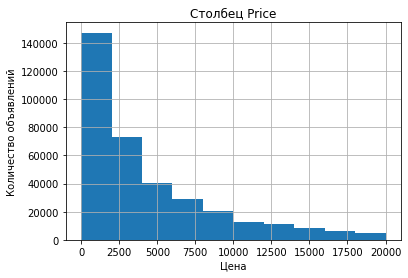

In [17]:
plt.xlabel("Цена")
plt.ylabel("Количество объявлений")
plt.title("Столбец Price")
df['Price'].hist()
plt.show()

Так как цены ограничены 0, то мы видим часть нормального распределения. По этому можно сделать вывод, что данных достаточно и они имеют хорошие значнения для обучения.

Неплохо бы еще посмотреть объявления с 0 цеником.

In [18]:
len(df.loc[df['Price'] == 0])

10772

In [19]:
df.loc[df['Price'] == 0].sample(5, random_state = RANDOM_STATE)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
327795,2016-03-26 15:52:30,0,sedan,2003,auto,177,e_klasse,150000,10,petrol,mercedes_benz,no,2016-03-26 00:00:00,0,95100,2016-04-06 04:15:46
266479,2016-03-05 22:45:26,0,other,1997,manual,131,other,50000,9,petrol,fiat,yes,2016-03-05 00:00:00,0,50733,2016-03-08 12:17:09
106022,2016-04-02 14:50:26,0,coupe,2000,manual,133,other,150000,4,petrol,chrysler,no,2016-04-02 00:00:00,0,68309,2016-04-06 13:17:41
32515,2016-03-20 22:47:53,0,bus,2004,manual,0,zafira,150000,0,cng,opel,NaN,2016-03-20 00:00:00,0,33615,2016-04-07 09:17:40
331230,2016-03-21 20:46:44,0,NaN,2005,manual,0,NaN,5000,0,NaN,sonstige_autos,no,2016-03-21 00:00:00,0,15827,2016-04-02 23:16:03


Очень странные объявления с 0 ценой. Нужно думать что с нимим делать. После всех корректировок, создадим второй дата сет без нулевых цен и посмотрим на чем модель обучится лучше.

#### VehicleType

По скольку это тип кузова автомобиля, можно посмотреть на количество типов и их распредление. Так же в этом столбце есть пропуски, нужно их оценить.

In [20]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [21]:
df['VehicleType'].isna().sum()

37490

In [22]:
f'сколько стостваляют пропуски: {(df["VehicleType"].isna().sum()/len(df)*100).round(2)}%'

'сколько стостваляют пропуски: 10.58%'

<AxesSubplot:title={'center':'Столбец VehicleType'}, ylabel='Тип кузова'>

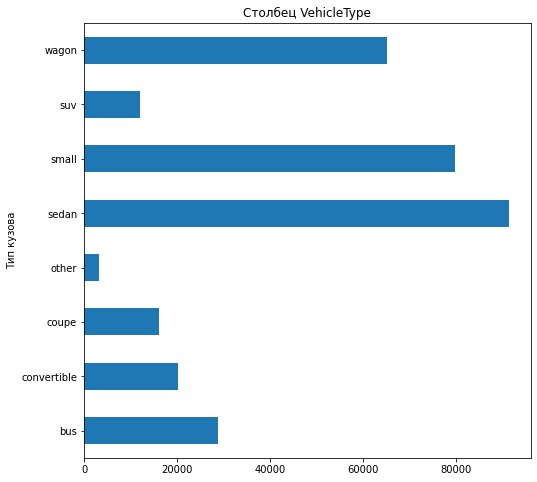

In [23]:
df.pivot_table(index = "VehicleType",
               values = "Price",
               aggfunc = "count").plot(y = "Price", 
                                      kind = "barh", 
                                      legend = False,
                                      figsize = (8,8),
                                      ylabel = "Килочество объявлений",
                                      xlabel='Тип кузова',
                                      title='Столбец VehicleType')

По скольку удаление столбцов с пропусками это достаточно большая потеря данных, почти 11%, по этому заменим все наны на категорию "unknow".

In [24]:
df['VehicleType'] = df['VehicleType'].fillna('unknow')

<AxesSubplot:title={'center':'Столбец VehicleType'}, ylabel='Тип кузова'>

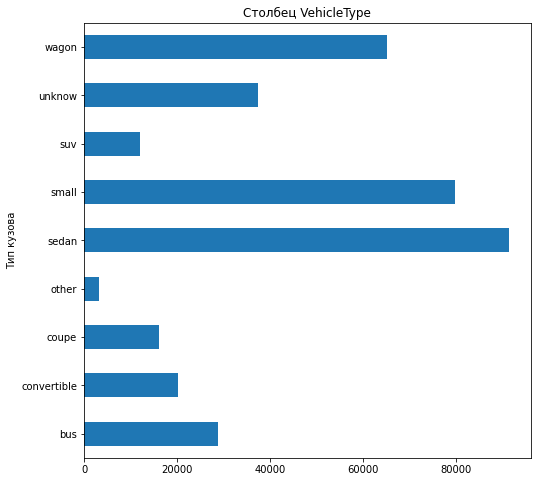

In [25]:
df.pivot_table(index = "VehicleType",
               values = "Price",
               aggfunc = "count").plot(y = "Price", 
                                      kind = "barh", 
                                      legend = False,
                                      figsize = (8,8),
                                      ylabel = "Килочество объявлений",
                                      xlabel='Тип кузова',
                                      title='Столбец VehicleType')

Отлично, можно двигаться к другому столбцу.

#### RegistrationYear

Тут пропусков нет, по этому просто посмотрим на рапределение по годам.

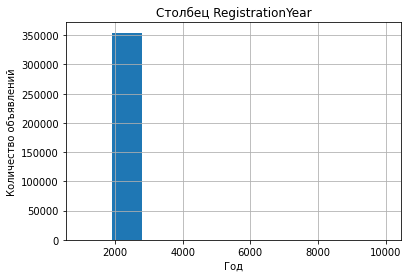

In [26]:
plt.xlabel("Год")
plt.ylabel("Количество объявлений")
plt.title("Столбец RegistrationYear")
df['RegistrationYear'].hist()
plt.show()

по диаграмме видно, что есть какие-то значения выходящие за 3000 год, очевидно это выбросы. Посмторим сколько их и какие вообще етсь значения.

In [27]:
df['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

Разброс очень большой от 1000 года, до 9999. Вызвано скорее всего человеческим фактором. Для начла посмотрим на строки раньше 1910 года.

In [28]:
df.loc[df['RegistrationYear'] < 1910]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
622,2016-03-16 16:55:09,0,unknow,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16 00:00:00,0,44628,2016-03-20 16:44:37
16062,2016-03-29 23:42:16,190,unknow,1000,NaN,0,mondeo,5000,0,NaN,ford,NaN,2016-03-29 00:00:00,0,47166,2016-04-06 10:44:58
18224,2016-03-09 17:49:44,7999,unknow,1500,manual,224,impreza,5000,3,NaN,subaru,NaN,2016-03-09 00:00:00,0,53577,2016-03-15 05:15:17
34332,2016-04-01 06:02:10,450,unknow,1800,NaN,1800,NaN,5000,2,NaN,mitsubishi,no,2016-04-01 00:00:00,0,63322,2016-04-01 09:42:30
38875,2016-03-19 23:54:40,1234,unknow,1234,NaN,26,NaN,5000,1,NaN,trabant,NaN,2016-03-19 00:00:00,0,38518,2016-04-06 03:15:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323424,2016-03-26 20:58:27,30,unknow,1000,NaN,0,NaN,5000,0,NaN,audi,NaN,2016-03-26 00:00:00,0,37574,2016-04-06 12:17:27
325719,2016-03-30 11:36:35,400,unknow,1000,NaN,0,NaN,5000,0,NaN,mercedes_benz,NaN,2016-03-30 00:00:00,0,8060,2016-04-01 06:16:46
340739,2016-04-04 23:55:47,700,unknow,1600,manual,1600,a3,150000,4,petrol,audi,no,2016-04-04 00:00:00,0,86343,2016-04-05 06:44:07
348810,2016-03-22 00:38:15,1,unknow,1000,NaN,1000,NaN,150000,0,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0,41472,2016-04-05 14:18:01


Объявления достаточно "живые" можно предположить, что люди просто опечатались или вводили две цифры при подаче объявления, а алгоритм дописал 00.

Тогда если объявление заканчиватеся на 00 то можно первые две цифры перенести в конец, остается определить к какому столетию будет относиться автомобиль, к 20 веку или 21. Можно это оценить по дате создания объявления.

In [29]:
def year_cor (df):
    if df['RegistrationYear']%100 == 0:
        if int(df['DateCreated'][2:4]) > df['RegistrationYear']//100:
            return 2000+df['RegistrationYear']//100
        else:
            return 1900+df['RegistrationYear']//100
    else:
        if int(df['DateCreated'][2:4]) > df['RegistrationYear']%100:
            return 2000+df['RegistrationYear']%100
        else:
            return 1900+df['RegistrationYear']%100

In [30]:
df.loc[df['RegistrationYear'] < 1910]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
622,2016-03-16 16:55:09,0,unknow,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16 00:00:00,0,44628,2016-03-20 16:44:37
16062,2016-03-29 23:42:16,190,unknow,1000,NaN,0,mondeo,5000,0,NaN,ford,NaN,2016-03-29 00:00:00,0,47166,2016-04-06 10:44:58
18224,2016-03-09 17:49:44,7999,unknow,1500,manual,224,impreza,5000,3,NaN,subaru,NaN,2016-03-09 00:00:00,0,53577,2016-03-15 05:15:17
34332,2016-04-01 06:02:10,450,unknow,1800,NaN,1800,NaN,5000,2,NaN,mitsubishi,no,2016-04-01 00:00:00,0,63322,2016-04-01 09:42:30
38875,2016-03-19 23:54:40,1234,unknow,1234,NaN,26,NaN,5000,1,NaN,trabant,NaN,2016-03-19 00:00:00,0,38518,2016-04-06 03:15:22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323424,2016-03-26 20:58:27,30,unknow,1000,NaN,0,NaN,5000,0,NaN,audi,NaN,2016-03-26 00:00:00,0,37574,2016-04-06 12:17:27
325719,2016-03-30 11:36:35,400,unknow,1000,NaN,0,NaN,5000,0,NaN,mercedes_benz,NaN,2016-03-30 00:00:00,0,8060,2016-04-01 06:16:46
340739,2016-04-04 23:55:47,700,unknow,1600,manual,1600,a3,150000,4,petrol,audi,no,2016-04-04 00:00:00,0,86343,2016-04-05 06:44:07
348810,2016-03-22 00:38:15,1,unknow,1000,NaN,1000,NaN,150000,0,NaN,sonstige_autos,NaN,2016-03-21 00:00:00,0,41472,2016-04-05 14:18:01


In [31]:
df.loc[df['RegistrationYear'] < 1910, 'RegistrationYear'] = df.loc[df['RegistrationYear'] < 1910].apply(year_cor, axis =1 )

In [32]:
df['RegistrationYear'].sort_values().unique()

array([1910, 1915, 1916, 1918, 1919, 1920, 1923, 1925, 1927, 1928, 1929,
       1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940,
       1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951,
       1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962,
       1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973,
       1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984,
       1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000, 3200,
       3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600,
       5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200, 8455,
       8500, 8888, 9000, 9229, 9450, 9996, 9999], dtype=int64)

По такой же системе можно и откорректировать года больше 2019

In [33]:
df.loc[df['RegistrationYear'] > 2019, 'RegistrationYear'] = df.loc[df['RegistrationYear'] > 2019].apply(year_cor, axis =1 )

In [34]:
df['RegistrationYear'].sort_values().unique()

array([1910, 1915, 1916, 1918, 1919, 1920, 1922, 1923, 1925, 1927, 1928,
       1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019], dtype=int64)

Вроде бы получилось, посмотрим теперь на распределение по годам.

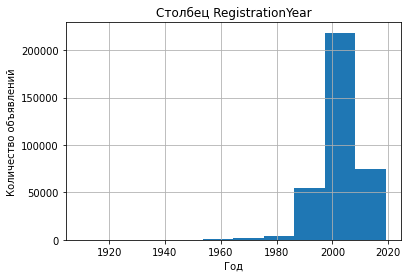

In [35]:
plt.xlabel("Год")
plt.ylabel("Количество объявлений")
plt.title("Столбец RegistrationYear")
df['RegistrationYear'].hist()
plt.show()

По скольку дата регистрации ораничина датой выгрузки, а это 2016 год, объявления с годом больше 2016 быть не могут.

In [36]:
df.loc[df['RegistrationYear'] > 2016, 'RegistrationYear'].count()/len(df)*100

4.070856897738946

4% данных, думаю можно их просто убрать.

In [37]:
df = df.drop(index = df.loc[df['RegistrationYear'] > 2016].index).reset_index(drop=True)

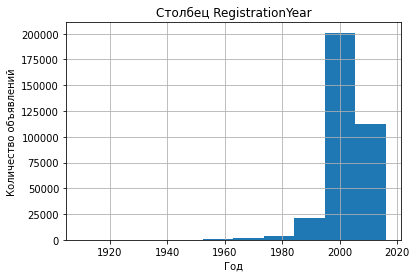

In [38]:
plt.xlabel("Год")
plt.ylabel("Количество объявлений")
plt.title("Столбец RegistrationYear")
df['RegistrationYear'].hist()
plt.show()

Уже выглядит на много лучше, основные объявления располагаются в промежутке от 1980 до 2019 года, похоже на правду.

#### Gearbox

Тут все должно быть просто, всего 4 значения, автомат, механика, вариатор и пропуск, посмотрим.

In [39]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

Даже вариатора нету, ну ладно, посмотрим сколько пропусков.

In [40]:
df['Gearbox'].isna().sum()

18047

Почти 20к, много, думаем что можно сдлеать.

Посмотри сколько пропусков до 1950 года.

In [41]:
df.loc[df['RegistrationYear'] < 1950, 'Gearbox'].isna().sum()

129

Всего 129, мало, но лучше чем ничего. Эти пропуски точно можно заменить на механику, тк примерно с 50 года начали устанавливать АККП на автомобили.

In [42]:
df.loc[df['RegistrationYear'] < 1950, 'Gearbox'] = df.loc[df['RegistrationYear'] < 1950, 'Gearbox'].fillna('manual')

Удалять данные строки не хочется, большая потеря будет, можно тогда просто заменить на 'unknow'.

In [43]:
df['Gearbox'] = df['Gearbox'].fillna('unknown')

In [44]:
df['Gearbox'].isna().sum()

0

Ну и для успокоения, посмотрим рапределение.

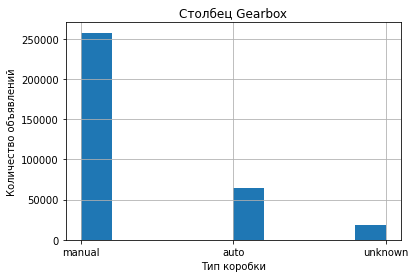

In [45]:
plt.xlabel("Тип коробки")
plt.ylabel("Количество объявлений")
plt.title("Столбец Gearbox")
df['Gearbox'].hist()
plt.show()

Как и следовало ожидать, механики на рынке больше, чем автоматов, все как в жизни.

#### Power

Тут пропусков нет, но наверняка есть аномалии, посмотрим.

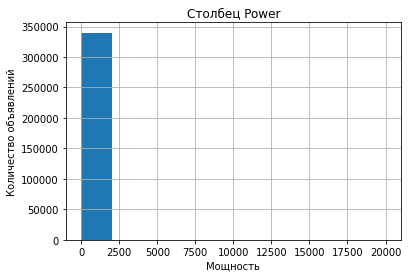

In [46]:
plt.xlabel("Мощность")
plt.ylabel("Количество объявлений")
plt.title("Столбец Power")
df['Power'].hist()
plt.show()

Не понятно. Сузим разброс. До 500 л.с. будет не плохо.

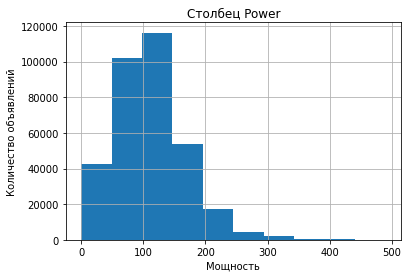

In [47]:
plt.xlabel("Мощность")
plt.ylabel("Количество объявлений")
plt.title("Столбец Power")
df.loc[df['Power'] < 500, 'Power'].hist()
plt.show()

На этом диапозоне все хорошо, посмотрим что творится за его пределами.

In [48]:
df.loc[df['Power'] > 500, 'Power'].count()

432

тут всего 459 объявлений, посмотрим какие есть значения.

In [49]:
df.loc[df['Power'] > 500, 'Power'].sort_values().unique()

array([  504,   505,   507,   508,   510,   514,   515,   517,   519,
         520,   521,   525,   530,   540,   541,   544,   550,   551,
         553,   560,   572,   574,   579,   580,   584,   585,   599,
         600,   601,   602,   603,   604,   606,   610,   612,   620,
         640,   645,   650,   651,   671,   678,   682,   685,   696,
         700,   702,   703,   732,   743,   750,   751,   754,   771,
         776,   800,   805,   850,   851,   871,   900,   902,   903,
         907,   909,   923,   950,   952,   953,   960,   998,   999,
        1000,  1001,  1002,  1003,  1004,  1005,  1011,  1012,  1016,
        1017,  1021,  1024,  1054,  1055,  1056,  1062,  1079,  1082,
        1090,  1100,  1102,  1103,  1105,  1111,  1115,  1120,  1149,
        1151,  1158,  1160,  1162,  1164,  1199,  1200,  1202,  1221,
        1223,  1230,  1239,  1240,  1241,  1250,  1256,  1275,  1288,
        1299,  1300,  1312,  1317,  1324,  1339,  1360,  1362,  1363,
        1367,  1390,

По скольку даже формула 1 имеет на своем борту двигатель 600 л.с., а гипер кары имеют двигатели в районе 1000 л.с., думаю эти объявления явно имеют ошибки. По этому не видя здесь каких-то закономерностей, просто удалим эти значения.

In [50]:
df = df.drop(index = df.loc[df['Power'] > 500].index).reset_index(drop=True)

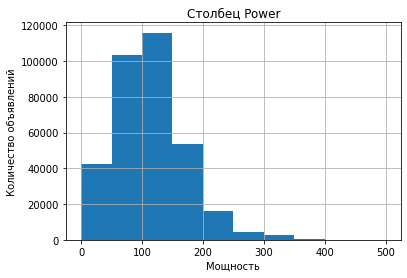

In [51]:
plt.xlabel("Мощность")
plt.ylabel("Количество объявлений")
plt.title("Столбец Power")
df['Power'].hist()
plt.show()

Еще вопрос к 0 значениям.

In [52]:
df.loc[df['Power'] == 0, 'Power'].count()

36580

Их так же достаточно много, постутпим как и с колонкой 'Price'.

#### Model

Тут очень много пропусков. Будем разбираться.

In [53]:
len(df['Model'].unique())

251

In [54]:
df['Model'].isna().sum()

17649

251 модель, думаю смотреть на их распределение нет смысла, будет не информативно. По скольку пропусков много, просто заменим их на "unknow", как и в других категориях.

In [55]:
df['Model'] = df['Model'].fillna('unknown')

In [56]:
df['Model'].isna().sum()

0

Еще можно посмотреть на 10 самых популярных моделей.

In [57]:
df['Model'].value_counts().head(10)

golf        27601
other       23848
3er         19212
unknown     17649
polo        12439
corsa       11930
astra       10324
passat       9832
a4           9689
c_klasse     8105
Name: Model, dtype: int64

"other" почти наравне с лидером "golf", возможно организаторам стоит расширить базу по моделям.

#### Kilometer

Тут также нет пропусков, но наверняка есть не логичные значения, посмотрим на распределение.

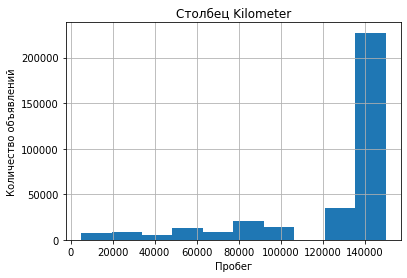

In [58]:
plt.xlabel("Пробег")
plt.ylabel("Количество объявлений")
plt.title("Столбец Kilometer")
df['Kilometer'].hist()
plt.show()

Интересно, большое количство объявлений с пробегом больше 125к КМ, интересно почему.

In [59]:
df['Kilometer'].value_counts()

150000    227330
125000     35009
100000     14405
90000      11187
80000       9746
70000       8356
60000       7277
50000       6063
5000        6001
40000       4810
30000       4311
20000       3809
10000       1187
Name: Kilometer, dtype: int64

картина проясняется, видимо в форме объявления нельзя написать точный пробег, а можно только выбрать приблизительный. Так же видно что после 100к шаг увеличиватется, а после 150к, возможно, нельзя выбрать большее значение.

В любом случае сильно тут ничего не сделаешь.

#### RegistrationMonth

Пропусков нет, все здорово, можно только посмотеть в какой месяц чаще регистрировали машины. Логика подсказывает, что должно быть +- равномерно, но кто знает.

<AxesSubplot:title={'center':'Столбец RegistrationMonth'}, ylabel='Номер месяца регистрации'>

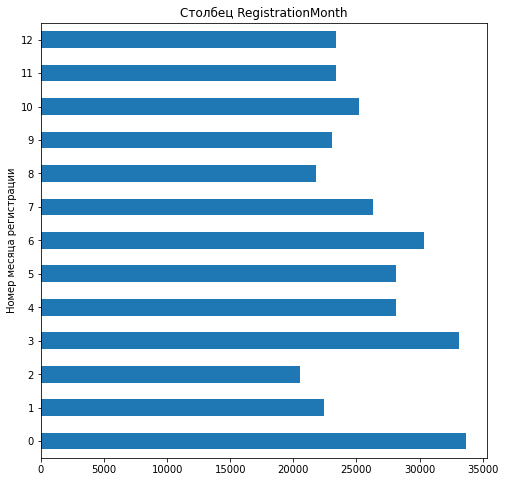

In [60]:
df.pivot_table(index = "RegistrationMonth",
               values = "Price",
               aggfunc = "count").plot(y = "Price", 
                                      kind = "barh", 
                                      legend = False,
                                      figsize = (8,8),
                                      ylabel = "Килочество объявлений",
                                      xlabel='Номер месяца регистрации',
                                      title='Столбец RegistrationMonth')

In [61]:
df['RegistrationMonth'].value_counts()

0     33689
3     33163
6     30349
4     28160
5     28104
7     26274
10    25229
12    23354
11    23353
9     23055
1     22435
8     21803
2     20523
Name: RegistrationMonth, dtype: int64

Почти угадал, видим большой скачок после нового года, оно и очивидно, большинство салонов делают в этот период большую скидку. Дальше есть Март и Июнь, наверняка есть и тут свои закономерности, но они нам сильно не помогут. 

#### FuelType

Этот столбец имеет внушительное количество попусков.

In [62]:
df['FuelType'].isna().sum()

27295

In [63]:
df['FuelType'].value_counts()

petrol      209753
gasoline     96238
lpg           5155
cng            541
hybrid         225
other          196
electric        88
Name: FuelType, dtype: int64

Пропусков много, категорий тоже хватает. Поступим как и в других категориальных столбцах, "unknown" наш выбор.

In [64]:
df['FuelType'] = df['FuelType'].fillna('unknown')

Теперь есть еще один подготовленный столбец.

#### Brand 

Пропусков нет, можно просто оценить количество брендов и их распределение.

In [65]:
df['Brand'].value_counts()

volkswagen        73140
opel              37964
bmw               35764
mercedes_benz     30966
audi              28443
ford              24144
renault           16907
peugeot           10620
fiat               9149
seat               6526
mazda              5402
skoda              5357
smart              5023
citroen            4907
nissan             4740
toyota             4455
hyundai            3447
sonstige_autos     3224
volvo              3139
mini               3092
mitsubishi         2907
honda              2685
kia                2362
suzuki             2246
alfa_romeo         2234
chevrolet          1698
chrysler           1391
dacia               874
daihatsu            780
porsche             744
subaru              744
jeep                653
trabant             580
land_rover          538
saab                515
daewoo              512
jaguar              497
rover               460
lancia              444
lada                218
Name: Brand, dtype: int64

Брендов много, на удивление очень мало отечественных. Возможно заказчик иностранная платформа.

#### Repaired

Это самый бедный на информацию столбец.

In [66]:
df["Repaired"].isna().sum()

64795

In [67]:
f'Пропусков аж {((df["Repaired"].isna().sum()/len(df))*100).round(2)} %'

'Пропусков аж 19.09 %'

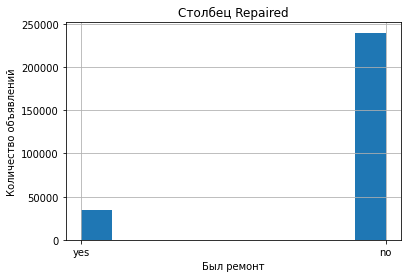

In [68]:
plt.xlabel("Был ремонт")
plt.ylabel("Количество объявлений")
plt.title("Столбец Repaired")
df['Repaired'].hist()
plt.show()

Как видно у нас пропусков больше чем машин с ремонтом, терять 20% информации совсем не хочется, по этому выход есть "unknow".

In [69]:
df['Repaired'] = df['Repaired'].fillna('unknow')

Столбец готов к дальнейшей работе.

#### DateCreated

Тут все хорошо, как и с другим столбцом даты, просто переведем его в нужный формат.

In [70]:
df['DateCreated'] = pd.to_datetime(df['DateCreated'], format = '%Y-%m-%d %H:%M:%S')

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339491 entries, 0 to 339490
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        339491 non-null  datetime64[ns]
 1   Price              339491 non-null  int64         
 2   VehicleType        339491 non-null  object        
 3   RegistrationYear   339491 non-null  int64         
 4   Gearbox            339491 non-null  object        
 5   Power              339491 non-null  int64         
 6   Model              339491 non-null  object        
 7   Kilometer          339491 non-null  int64         
 8   RegistrationMonth  339491 non-null  int64         
 9   FuelType           339491 non-null  object        
 10  Brand              339491 non-null  object        
 11  Repaired           339491 non-null  object        
 12  DateCreated        339491 non-null  datetime64[ns]
 13  NumberOfPictures   339491 non-null  int64   

Здорово, идем дальше.

#### NumberOfPictures

Полный столбец, посмотрим как много фотографий пользователи добавляют

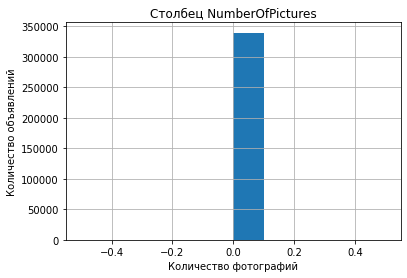

In [72]:
plt.xlabel("Количество фотографий")
plt.ylabel("Количество объявлений")
plt.title("Столбец NumberOfPictures")
df['NumberOfPictures'].hist()
plt.show()

По графику в основном 0. 

In [73]:
df['NumberOfPictures'].describe()

count    339491.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: NumberOfPictures, dtype: float64

Очень интересно, у всех объявлений нет фотографий. Тут нужно задать вопрос людям которые скачивали данные, столбец важный, а даных нет. Ну по скольку до этих людей нам не добраться, просто уберем этот не информативный столбец.

In [74]:
df = df.drop(['NumberOfPictures'], axis=1).reset_index(drop=True)

Вот и все с этим столбцом.

#### PostalCode

Тут столбец без пропусков и полный. Единственное что можно сделать это посмотреть откуда люди, чаще всего публикуют объявления.

In [75]:
df['PostalCode'].value_counts()

10115    816
65428    575
66333    326
32257    299
44145    299
        ... 
87569      1
91726      1
89368      1
95356      1
38325      1
Name: PostalCode, Length: 8138, dtype: int64

Как подсказывает интернет 5и значные индексы использует Америка и Германия и если предположение верное, то больше всего обявлений из Нью-Йорка или Берлина. Учитывая подавляющее большинство немецких машин в объявлении, можно смело заявить что это Немецкая платформа.

#### LastSeen

Ничего нового, столбец с датой в нужный формат.

In [76]:
df['LastSeen'] = pd.to_datetime(df['LastSeen'], format = '%Y-%m-%d %H:%M:%S')

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339491 entries, 0 to 339490
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        339491 non-null  datetime64[ns]
 1   Price              339491 non-null  int64         
 2   VehicleType        339491 non-null  object        
 3   RegistrationYear   339491 non-null  int64         
 4   Gearbox            339491 non-null  object        
 5   Power              339491 non-null  int64         
 6   Model              339491 non-null  object        
 7   Kilometer          339491 non-null  int64         
 8   RegistrationMonth  339491 non-null  int64         
 9   FuelType           339491 non-null  object        
 10  Brand              339491 non-null  object        
 11  Repaired           339491 non-null  object        
 12  DateCreated        339491 non-null  datetime64[ns]
 13  PostalCode         339491 non-null  int64   

Отлично, на этапе создания новых столбцов, возможно это пригодится.

### Новые столбцы

Еще раз посмотрим на то что у нас есть.

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339491 entries, 0 to 339490
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        339491 non-null  datetime64[ns]
 1   Price              339491 non-null  int64         
 2   VehicleType        339491 non-null  object        
 3   RegistrationYear   339491 non-null  int64         
 4   Gearbox            339491 non-null  object        
 5   Power              339491 non-null  int64         
 6   Model              339491 non-null  object        
 7   Kilometer          339491 non-null  int64         
 8   RegistrationMonth  339491 non-null  int64         
 9   FuelType           339491 non-null  object        
 10  Brand              339491 non-null  object        
 11  Repaired           339491 non-null  object        
 12  DateCreated        339491 non-null  datetime64[ns]
 13  PostalCode         339491 non-null  int64   

In [79]:
df.sample(5, random_state=RANDOM_STATE)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
63862,2016-03-18 00:58:28,350,wagon,2001,manual,102,other,150000,6,petrol,mitsubishi,no,2016-03-18,32756,2016-04-05 22:15:33
223653,2016-03-20 16:57:18,0,sedan,1989,manual,26,601,100000,7,petrol,trabant,no,2016-03-20,18337,2016-03-24 09:45:40
202366,2016-03-12 16:44:39,3000,sedan,2001,manual,90,golf,150000,11,gasoline,volkswagen,no,2016-03-12,98746,2016-03-28 23:44:58
284258,2016-03-18 07:52:05,19900,convertible,1990,auto,190,sl,30000,8,petrol,mercedes_benz,no,2016-03-18,73033,2016-03-18 07:52:05
40389,2016-03-20 09:56:22,450,wagon,1998,manual,90,escort,90000,0,petrol,ford,unknow,2016-03-20,47475,2016-03-20 10:39:55


Кажется, что такие точные даты нам не нужны, по этому можно оставить по столбцу месяца и года для каждой даты.

In [80]:
for col in ['DateCrawled', 'DateCreated', 'LastSeen']:
    df[f'{col}Year']=pd.DatetimeIndex(df[col]).year
    df[f'{col}Month']=pd.DatetimeIndex(df[col]).month
        

In [81]:
df.sample(5, random_state=RANDOM_STATE)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,...,Repaired,DateCreated,PostalCode,LastSeen,DateCrawledYear,DateCrawledMonth,DateCreatedYear,DateCreatedMonth,LastSeenYear,LastSeenMonth
63862,2016-03-18 00:58:28,350,wagon,2001,manual,102,other,150000,6,petrol,...,no,2016-03-18,32756,2016-04-05 22:15:33,2016,3,2016,3,2016,4
223653,2016-03-20 16:57:18,0,sedan,1989,manual,26,601,100000,7,petrol,...,no,2016-03-20,18337,2016-03-24 09:45:40,2016,3,2016,3,2016,3
202366,2016-03-12 16:44:39,3000,sedan,2001,manual,90,golf,150000,11,gasoline,...,no,2016-03-12,98746,2016-03-28 23:44:58,2016,3,2016,3,2016,3
284258,2016-03-18 07:52:05,19900,convertible,1990,auto,190,sl,30000,8,petrol,...,no,2016-03-18,73033,2016-03-18 07:52:05,2016,3,2016,3,2016,3
40389,2016-03-20 09:56:22,450,wagon,1998,manual,90,escort,90000,0,petrol,...,unknow,2016-03-20,47475,2016-03-20 10:39:55,2016,3,2016,3,2016,3


Отлично, необходимую информацию из этих столбцов мы получили, теперь их можно убрать.

In [82]:
df = df.drop(['DateCrawled', 'DateCreated', 'LastSeen'],axis=1).reset_index(drop=True)

In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339491 entries, 0 to 339490
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              339491 non-null  int64 
 1   VehicleType        339491 non-null  object
 2   RegistrationYear   339491 non-null  int64 
 3   Gearbox            339491 non-null  object
 4   Power              339491 non-null  int64 
 5   Model              339491 non-null  object
 6   Kilometer          339491 non-null  int64 
 7   RegistrationMonth  339491 non-null  int64 
 8   FuelType           339491 non-null  object
 9   Brand              339491 non-null  object
 10  Repaired           339491 non-null  object
 11  PostalCode         339491 non-null  int64 
 12  DateCrawledYear    339491 non-null  int64 
 13  DateCrawledMonth   339491 non-null  int64 
 14  DateCreatedYear    339491 non-null  int64 
 15  DateCreatedMonth   339491 non-null  int64 
 16  LastSeenYear       3

Больше вроде ничего создать не хочется, идем дальше.

### Unknow

Прежде чем переходить к обучению, можно еще подчистить нашу таблицу. Есть строки где 3 и больше категориальных признака отсутствуют. Думаю можно посмотреть на их количество и оценить на сколько они нужны.

In [84]:
def unknow_count (df):
    count = 0
    if df['VehicleType'] == 'unknown': count += 1
    if df['Gearbox'] == 'unknown': count += 1
    if df['Model'] == 'unknown': count += 1
    if df['FuelType'] == 'unknown': count += 1
    if df['Brand'] == 'unknown': count += 1 
    if df['Repaired'] == 'unknown': count += 1
    if count >= 3: 
        return True
    else: return False

In [85]:
con_unk = df.apply(unknow_count, axis = 1)

In [86]:
con_unk.sum()

2658

Почти 3 тысячи строк с пропусками в категориальных переменных. Если в этих строках еще и цена равна 0 тогда они точно не нужны.

In [87]:
len(df.loc[con_unk & (df['Price'] == 0)])

802

843 строки можно спокойно удалить.

In [88]:
df = df.drop(index = df.loc[con_unk & (df['Price'] == 0)].index, axis = 1).reset_index(drop=True)

В принципе тут все

### ОНЕ

По скольку будем использовать не только градиентный бустинг, но и линейную регрессию, необходимо подготовить категориальные переменные, будем исползовать OHE.

Если использовать просто OHE, то получим таблицу с количеством столбцов за 300 шт, кажется это лишнее. Основную массу дополнительных столбцов добавляют колонки с моделью и маркой автомобиля, еще раз посмотрим на них.

In [89]:
df['Model'].value_counts()

golf                  27601
other                 23848
3er                   19212
unknown               16847
polo                  12439
                      ...  
kalina                    6
serie_3                   4
rangerover                3
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 251, dtype: int64

Думаю если мы оставим 70% всех моделей, а остальные отнесем к категории "other" сильно ничего не потеряем.

In [90]:
df_ohe = df

In [91]:
models_count = df_ohe['Model'].value_counts()
leght = len(models_count)
models_sum = models_count.sum()
for i in range(leght):
    if models_count[:i+1].sum()/models_sum > .7: 
        break
i

29

Получается, 29 моделей составляют 70% от всех объявлений, для красивого чилса оставим 30 самых полпулярных.

In [92]:
model_70 = df['Model'].value_counts().head(30).index
model_70

Index(['golf', 'other', '3er', 'unknown', 'polo', 'corsa', 'astra', 'passat',
       'a4', 'c_klasse', '5er', 'e_klasse', 'a3', 'focus', 'fiesta', 'a6',
       '2_reihe', 'transporter', 'twingo', 'fortwo', 'vectra', 'a_klasse',
       'mondeo', '1er', '3_reihe', 'clio', 'touran', 'punto', 'zafira',
       'megane'],
      dtype='object')

In [93]:
def distribution_of_models (df):
    if df["Model"] not in model_70:
        df["Model"] = "other"
    return df

In [94]:
df_ohe = df_ohe.apply(distribution_of_models, axis = 1)

In [95]:
df_ohe['Model'].value_counts()

other          124166
golf            27601
3er             19212
unknown         16847
polo            12439
corsa           11930
astra           10324
passat           9832
a4               9689
c_klasse         8105
5er              7712
e_klasse         6623
a3               5759
focus            5624
fiesta           5546
a6               5419
2_reihe          4698
transporter      4661
twingo           4639
fortwo           4186
vectra           4085
a_klasse         3916
mondeo           3500
1er              3417
3_reihe          3367
clio             3359
touran           3257
punto            3134
zafira           2851
megane           2791
Name: Model, dtype: int64

Теперь конечно категория "other" встала на первое место, посмотрим как это скажется на моделе.

Столбец марок.

In [96]:
len(df_ohe['Brand'].value_counts())

40

В принципе их получилось чуть больше чем моделей, остваим как есть.

Для того что бы не было утечки данных прежде чем кодировать нужно данные разделить на тренировочную и тестовую. По этому само кодирование будет позже.

100 столбцов, думаю не плохо.

### 0 значения

По скольку некоторые важные значения имеют 0, можно создать отдельные таблице без этих строк.

In [97]:
df_zeroless = df.loc[
    (df['Price'] != 0) &
    (df['Power'] != 0)
]

In [98]:
len(df) - len(df_zeroless)

42176

Ушло 46к строк, весомое значение, интересно как скажется на результате.

Теперь вроде бы все готово для подготовки к обучению

### Фичи и ответы

Теперь необходимо разделить фичи и ответы, а так же выборки на тестовую и тренировочную.

In [99]:
train_df, test_df = train_test_split(df, test_size=.25, random_state=RANDOM_STATE)
train_df_zeroless, test_df_zeroless = train_test_split(df_zeroless, test_size=.25, random_state=RANDOM_STATE)

Выборки есть, теперь создадим кадированные выбокри.

In [100]:
cat_columns = train_df.select_dtypes(include='object').columns.to_list()
cat_columns

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']

In [101]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(train_df[cat_columns])

d:\Python\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False,
              sparse_output=False)

In [102]:
train_df_ohe = train_df.copy()
train_df_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(train_df[cat_columns])
train_df_ohe = train_df_ohe.drop(cat_columns, axis=1)

C:\Users\black\AppData\Local\Temp\ipykernel_22256\3397276756.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(train_df[cat_columns])
C:\Users\black\AppData\Local\Temp\ipykernel_22256\3397276756.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_df_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(train_df[cat_columns])
C:\Users\black\AppData\Local\Temp\ipykernel_22256\3397276756.py:2: PerformanceWarning: DataFrame is highly fragmen

In [103]:
test_df_ohe = test_df.copy()
test_df_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(test_df[cat_columns])
test_df_ohe = test_df_ohe.drop(cat_columns, axis=1)

cat_columns_zr = train_df_zeroless.select_dtypes(include='object').columns.to_list()

encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(train_df_zeroless[cat_columns_zr])

train_df_ohe_zeroless = train_df_zeroless.copy()
train_df_ohe_zeroless[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(train_df_zeroless[cat_columns_zr])
train_df_ohe_zeroless = train_df_ohe_zeroless.drop(cat_columns_zr, axis=1)

test_df_ohe_zeroless = test_df_zeroless.copy()
test_df_ohe_zeroless[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(test_df_zeroless[cat_columns_zr])
test_df_ohe_zeroless = test_df_ohe_zeroless.drop(cat_columns_zr, axis=1)

d:\Python\lib\site-packages\sklearn\preprocessing\_encoders.py:182: UserWarning: Found unknown categories in columns [2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\black\AppData\Local\Temp\ipykernel_22256\4101371514.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_df_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(test_df[cat_columns])
C:\Users\black\AppData\Local\Temp\ipykernel_22256\4101371514.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tes

In [104]:
train_df_features = train_df.drop(["Price"], axis= 1)
train_df_ans = train_df["Price"]
test_df_features = test_df.drop(["Price"], axis= 1)
test_df_ans = test_df["Price"]

train_df_zeroless_features = train_df_zeroless.drop(["Price"], axis= 1)
train_df_zeroless_ans = train_df_zeroless["Price"]
test_df_zeroless_features = test_df_zeroless.drop(["Price"], axis= 1)
test_df_zeroless_ans = test_df_zeroless["Price"]

train_df_ohe_features = train_df_ohe.drop(["Price"], axis= 1)
train_df_ohe_ans = train_df_ohe["Price"]
test_df_ohe_features = test_df_ohe.drop(["Price"], axis= 1)
test_df_ohe_ans = test_df_ohe["Price"]

train_df_ohe_zeroless_features = train_df_ohe_zeroless.drop(["Price"], axis= 1)
train_df_ohe_zerolesss_ans = train_df_ohe_zeroless["Price"]
test_df_ohe_zeroless_features = test_df_ohe_zeroless.drop(["Price"], axis= 1)
test_df_ohe_zeroless_ans = test_df_ohe_zeroless["Price"]

## Обучение моделей

Возьмем четыре модели для обучения, это "лес", "регрессия", CatBoost и LightGBM

### Лес

Поскольку у нас есть `GridSearchCV` то нам понадобятся только тестовая и тренировочная выборки.

Для леса важен масштаб, по этому применяем `StandardScaler`. Для леса будем использовать выборки с ОНЕ.

In [105]:
column = train_df_ohe_features.columns
scaler = StandardScaler()
scaler.fit(train_df_ohe_features[column])
pd.options.mode.chained_assignment = None

In [106]:
train_df_ohe_features[column] = scaler.transform(train_df_ohe_features[column])
test_df_ohe_features[column] = scaler.transform(test_df_ohe_features[column])

In [107]:
column = train_df_ohe_zeroless_features.columns
scaler = StandardScaler()
scaler.fit(train_df_ohe_zeroless_features[column])
pd.options.mode.chained_assignment = None

In [108]:
train_df_ohe_zeroless_features[column] = scaler.transform(train_df_ohe_zeroless_features[column])
test_df_ohe_zeroless_features[column] = scaler.transform(test_df_ohe_zeroless_features[column])

In [109]:
if GRID_OPTION == 1:
    parametrs = {'n_estimators' : range(250,851,200),
                'max_depth' :[8,9],
                'min_samples_leaf' : [6],
                'min_samples_split': [2]}
    rfr = GridSearchCV(RFR(random_state= RANDOM_STATE), 
                       parametrs, 
                       scoring = 'neg_root_mean_squared_error', 
                       verbose = 3,
                       cv=2)
    rfr.fit(train_df_ohe_features, train_df_ohe_ans)
    print (rfr.best_params_)
    print (rfr.best_score_)
    bot_send(f'{rfr.best_score_}')
    for s in rfr.best_params_:
        bot_send (f'{s}: {rfr.best_params_[s]}')
    MSE(test_df_ohe_ans, rfr.predict(test_df_ohe_features),squared=False)

In [110]:
if GRID_OPTION == 1:
    parametrs = {'n_estimators' : range(250,851,200),
                'max_depth' : [8,9],
                'min_samples_leaf' : [2],
                'min_samples_split': [2]}
    rfr_zr = GridSearchCV(RFR(random_state= RANDOM_STATE), 
                       parametrs, 
                       scoring = 'neg_root_mean_squared_error', 
                       verbose = 3,
                       cv=2)
    rfr_zr.fit(train_df_ohe_zeroless_features, train_df_ohe_zerolesss_ans)
    print (rfr_zr.best_params_)
    print (rfr_zr.best_score_)
    bot_send(f'{rfr_zr.best_score_}')
    for s in rfr_zr.best_params_:
        bot_send (f'{s}: {rfr_zr.best_params_[s]}')
    MSE(test_df_ohe_zeroless_ans, rfr_zr.predict(test_df_ohe_zeroless_features),squared=False)

После парочки прогонов гиперпараметров для леса, видно что лес с набором даных без нулей показывает лучшую метрику, по этому дальше будем подбирать параметры только для него.

In [111]:
if GRID_OPTION == 1: 
    parametrs = {'n_estimators' : range(650, 851, 100),
                'max_depth' : [9],
                'min_samples_leaf' : [2],
                'min_samples_split': [2]}
    rfr_zr = GridSearchCV(RFR(random_state= RANDOM_STATE), 
                       parametrs, 
                       scoring = 'neg_root_mean_squared_error', 
                       verbose = 3,
                       cv=2)
    rfr_zr.fit(train_df_ohe_zeroless_features, train_df_ohe_zerolesss_ans)
    print (rfr_zr.best_params_)
    print (rfr_zr.best_score_)
    bot_send(f'{rfr_zr.best_score_}')
    for s in rfr_zr.best_params_:
        bot_send (f'{s}: {rfr_zr.best_params_[s]}')
    MSE(test_df_ohe_zeroless_ans, rfr_zr.predict(test_df_ohe_zeroless_features),squared=False)

Перебрав гиперпараметры получили RMSE на тестовой выборке 1973,8. Не плохой результат, теперь посмотрим на время обучения для этих параметров и время предсказания.

In [112]:
start = time()
rfr_zr = RFR(random_state= RANDOM_STATE,
             max_depth=9,
             min_samples_leaf=2,
             min_samples_split=2,
             n_estimators=850)
rfr_zr.fit(train_df_ohe_zeroless_features, train_df_ohe_zerolesss_ans)
time_rfr_fit = time()-start

In [113]:
start = time()
rfr_zr_predict = rfr_zr.predict(test_df_ohe_zeroless_features)
time_rfr_pre = time()-start

In [114]:
rmse_rfr = MSE(test_df_ohe_zeroless_ans, rfr_zr_predict,squared=False)

In [115]:
display(f'время обучения {time_rfr_fit}')
display(f'время предсказания {time_rfr_pre}')
display(f'RMSE {rmse_rfr}')

'время обучения 2036.035537481308'

'время предсказания 4.909670114517212'

'RMSE 1964.880377268981'

Получили необходимые данные, потом соберем все в единую таблицу и будем принимать решение.

### LinearRegression

Тут все просто, пармаетров нету, просто обучаем и радуемся быстрым результатам.

In [116]:
start = time()
lr = LR()
lr.fit(train_df_ohe_features, train_df_ohe_ans)
time_lr_fit = time()-start
strat= time()
lr_predict = lr.predict(test_df_ohe_features)
time_lr_pre = time() - start
rmse_lr = MSE(test_df_ohe_ans, lr_predict,squared=False)

In [117]:
start = time()
lr_zr = LR()
lr_zr.fit(train_df_ohe_zeroless_features, train_df_ohe_zerolesss_ans)
time_lr_zr_fit = time()-start
strat= time()
lr_zr_predict = lr_zr.predict(test_df_ohe_zeroless_features)
time_lr_zr_pre = time() - start
rmse_lr_zr = MSE(test_df_ohe_zeroless_ans, lr_zr_predict,squared=False)

In [118]:
display('данные с нулями')
display(f'время обучения {time_lr_fit}')
display(f'время предсказания {time_lr_pre}')
display(f'RMSE {rmse_lr}')
display()
display('данные без нулей')
display(f'время обучения {time_lr_zr_fit}')
display(f'время предсказания {time_lr_zr_pre}')
display(f'RMSE {rmse_lr_zr}')

'данные с нулями'

'время обучения 6.825263500213623'

'время предсказания 7.019872426986694'

'RMSE 2741.5611500610107'

'данные без нулей'

'время обучения 5.729093313217163'

'время предсказания 5.765995264053345'

'RMSE 2571.7660942380962'

Как видно во втором случае модель показала лучше результаты, и по вермени и по ошибке, но все-равно не прошла порога в 2500.

### CatBoost

По скольку CatBoost умеет работать с категориальными величинами будем использовать для него df без OHE.

In [119]:
if GRID_OPTION == 1:
    parametrs = {'depth' : range(10,15,1),
                'iterations' : range(800,1201,100),
                'learning_rate' : [0.8,.9,1],
                'l2_leaf_reg': range(2,5)}
    cbr = GridSearchCV(CBR(random_seed= RANDOM_STATE,
                           logging_level='Silent',
                           cat_features = (['VehicleType',
                                            'Gearbox',
                                            'Model',
                                            'FuelType',
                                            'Brand',
                                            'Repaired'])), 
                       parametrs, 
                       scoring = 'neg_root_mean_squared_error',
                       verbose = 3,
                       cv=2)
    cbr.fit(train_df_features, train_df_ans)
    print (cbr.best_params_)
    print (cbr.best_score_)
    bot_send(f'{cbr.best_score_}')
    for s in cbr.best_params_:
        bot_send (f'{s}: {cbr.best_params_[s]}')
    MSE(test_df_ans, cbr.predict(test_df_features),squared=False)

Параметры есть, теперь будем обучать модель и замерять время. По скольку все модели показывают результаты лучше на выборке без нулей, ее и будем использовать.

In [120]:
start = time()
cbr = CBR(random_seed= RANDOM_STATE,
                       logging_level='Silent',
                       cat_features = (['VehicleType',
                                        'Gearbox',
                                        'Model',
                                        'FuelType',
                                        'Brand',
                                        'Repaired']),
         depth=10,
          iterations=1000,
          l2_leaf_reg=5,
          learning_rate=0.15)
cbr.fit(train_df_zeroless_features, train_df_zeroless_ans)
time_cbr_fit = time()-start
start= time()
cbr_predict = cbr.predict(test_df_zeroless_features)
time_cbr_pre = time() - start
rmse_cbr = MSE(test_df_zeroless_ans, cbr_predict,squared=False)

In [121]:
display(f'время обучения {time_cbr_fit}')
display(f'время предсказания {time_cbr_pre}')
display(f'RMSE {rmse_cbr}')

'время обучения 199.4037823677063'

'время предсказания 0.5465652942657471'

'RMSE 1495.244176053442'

### LGBMRegressor

In [122]:
if GRID_OPTION == 1: 
    parametrs = {'n_estimators' : range(1400,2201,200),
                'max_depth' : range(4,7)}
    lgb = GridSearchCV(LGB(random_state= RANDOM_STATE), 
                       parametrs, 
                       scoring = 'neg_root_mean_squared_error', 
                       verbose = 3,
                       cv=2)
    lgb.fit(train_df_ohe_features, train_df_ohe_ans)
    print (lgb.best_params_)
    print (lgb.best_score_)
    bot_send(f'{lgb.best_score_}')
    for s in lgb.best_params_:
        bot_send (f'{s}: {lgb.best_params_[s]}')
    MSE(test_df_ohe_ans, lgb.predict(test_df_ohe_features),squared=False)

парметры получили, теперь обучение.

In [123]:
start = time()
lgb_zr = LGB(n_estimators = 2000,
            max_depth = 4,
            random_state= RANDOM_STATE)
lgb_zr.fit(train_df_ohe_zeroless_features, train_df_ohe_zerolesss_ans)
time_lgb_zr_fit = time() - start
start = time()
lbg_zr_predict = lgb_zr.predict(test_df_ohe_zeroless_features)
time_lgb_zr_pre = time() - start
rmse_lgb_zr = MSE(test_df_ohe_zeroless_ans,lbg_zr_predict,squared=False)

In [124]:
display(f'время обучения {time_lgb_zr_fit}')
display(f'время предсказания {time_lgb_zr_pre}')
display(f'RMSE {rmse_lgb_zr}')

'время обучения 6.742169380187988'

'время предсказания 1.178846836090088'

'RMSE 1562.6920693283548'

## Анализ моделей

Теперь соберем все данные в единую таблицу и можно производить сравнение.

In [125]:
results = pd.DataFrame({'name':['RandomForestRegressor','LinearRegression','CatBoostRegressor','LGBMRegressor'],
                       'fit_time':[time_rfr_fit, time_lr_zr_fit, time_cbr_fit, time_lgb_zr_fit],
                       'pre_time':[time_rfr_pre, time_lr_zr_pre, time_cbr_pre, time_lgb_zr_pre],
                       'RMSE':[rmse_rfr, rmse_lr_zr, rmse_cbr, rmse_lgb_zr]})

In [126]:
results

,name,fit_time,pre_time,RMSE
0,RandomForestRegressor,2036.035537,4.909670,1964.880377
1,LinearRegression,5.729093,5.765995,2571.766094
2,CatBoostRegressor,199.403782,0.546565,1495.244176
3,LGBMRegressor,6.742169,1.178847,1562.692069


In [127]:
(results
 .style
 .background_gradient(cmap='bwr',axis=0)
 )

,name,fit_time,pre_time,RMSE
0,RandomForestRegressor,2036.035537,4.909670,1964.880377
1,LinearRegression,5.729093,5.765995,2571.766094
2,CatBoostRegressor,199.403782,0.546565,1495.244176
3,LGBMRegressor,6.742169,1.178847,1562.692069


Как видим бустинг показал наилучший результат на предсказании, за ними следует случайный лес, в конце идет линейная регрессия, которая не смогла пройти порог. По скольку у CatBoost и LGBM результаты очень схожи, отдаем предпочтение LGBM, так как у нее вермя обучения в разы меньше.

## Вывод

Произведя всю необходимую работу, выяснилось, что нулевые значения очень влияют на итоговый результат. Были обучены 4 модели, одна из которых не смогла пройти порог в 2500 RMSE. Остальные смогли опустить планку ниже 2000, но при этом рандомный лес обучался очень долго, в районе 15 минут, что не подходит под условия заказчика. Остаются два градиентных бустинга, которые показали схожие результаты, но LGBMRegressor обучается в разы быстрее, что и сделало его лучшим среди всех.